## FPUT (simple case)

Consider the hamiltonian (dimensionless) below
\begin{equation}
H(\vec{q},\vec{p})=\sum_{n=0}^{N-1}\Bigr[ \frac{p_n^2}{2}+\frac{(q_{n+1}-q_n)^2}{2}\Bigr]\\
\vec{q} = [q_1, \dots, q_n,\dots, q_N]\\
\vec{p} = [p_1, \dots, p_n, \dots,p_N]\\
\end{equation}

With the initial condition of the following form:\
\begin{equation}
q_n^{(t=0)}=Asin(\frac{\pi n}{N})\\p_n(0)=0
\end{equation}

And fixed ends conditions:\
\begin{equation}
q_0 = q_N = p_0 = p_N = 0
\end{equation}

<!-- The dependence between $q_n$ and $p_n$ are from the hamiltonian $H_n$ is
\begin{equation}
p_n = \sqrt{2E_n-k(q_{n+1}-q_n)^2}, \\
E_n=H_n, H = \sum_{n=0}^{N-1}H_n
\end{equation} -->

then, $\dot{q_n}$ and $\dot{p_n}$ would be

\begin{equation}
\dot{q_n}^{(t)}=\frac{\partial H}{\partial p_n}=p_n^{(t)}
\\
\dot{p_n}^{(t)}=-\frac{\partial H}{\partial q_n}=q_{n-1}^{(t)}+q_{n+1}^{(t)}-2q_n^{(t)}
\end{equation}



In [369]:
import numpy as np
import matplotlib.pyplot as plt

## Initial variables
# Assumes that len(p)=len(q)>=3

M = 3 # total number of oscillators
A = 0.8 # amplitude
q = A*np.sin(np.linspace(0,np.pi,M)) # oscillator position
p = np.zeros(M) # oscillator momentum
t_a = 0.0 # start of the interval
t_b = 200.0 # end of the interval
N = 1000 # number of steps
dt = (t_b-t_a)/N # size of a single step

## Calculates p_dot according EOM
# Notice that in the simple case Hamiltonian, q_dot just equals to p
def p_dot_update_simp(q): 
    p_dot_tem = np.zeros(M)
    for i in range(M):
        if i==0: # left boundary case
            p_dot_tem[0]=q[1]+q[-1]-2*q[0]
        elif i==M-1: # right boundary case
            p_dot_tem[M-1]=q[0]+q[M-2]-2*q[M-1]
        else:
            p_dot_tem[i]=q[i+1]+q[i-1]-2*q[i]
    return p_dot_tem

### * Euler Method (symplectic)

#### Important: Symplectic integrator or non-symplectic integrator?

For a **symplectic** Euler, it's calculated as the following:

\begin{equation}
q_n^{(t+dt)}=q_n^{(t)}+dt\cdot \dot{q_n}^{(t)}
\\
p_n^{(t+dt)}=p_n^{(t)}+dt\cdot \dot{p_n}^{(t+dt)}
\end{equation}

For a **non-symplectic** Euler,

\begin{equation}
q_n^{(t+dt)}=q_n^{(t)}+dt\cdot \dot{q_n}^{(t)}
\\
p_n^{(t+dt)}=p_n^{(t)}+dt\cdot \dot{p_n}^{(t)}
\end{equation}


<Figure size 640x480 with 0 Axes>

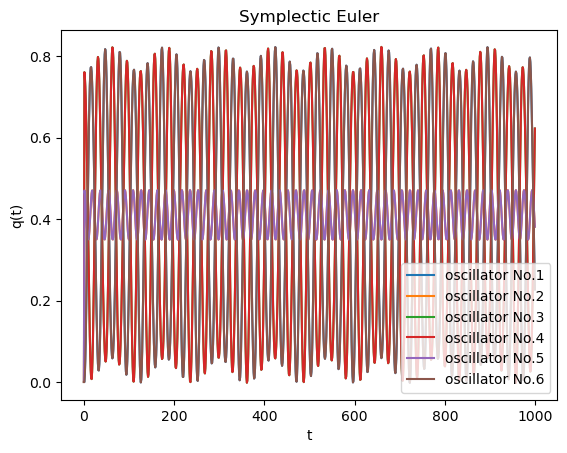

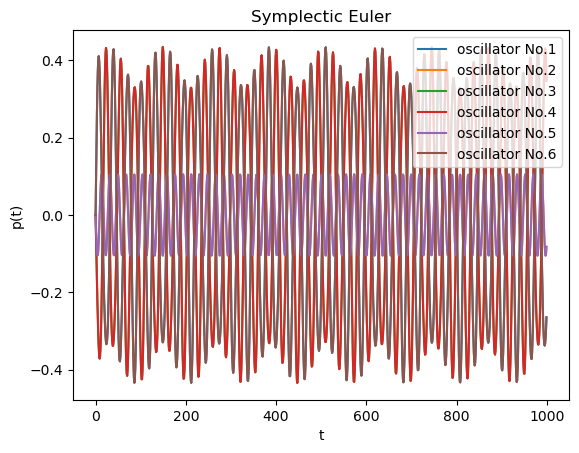

<Figure size 640x480 with 0 Axes>

In [370]:
## Euler Method

# Symplectic

def euler_evol_sym(q, p, update):
    p = p.copy()
    q = q.copy()
    q_dot = p # old q
    q_matrix = np.zeros([N,M]) # every column j stores the time evolution of oscillator j's position
    p_matrix = np.zeros([N,M]) # every column j stores the time evolution of oscillator j's momentum
    for t in range(1,N):
        q = q_dot*dt + q #first update p and q, then update p_dot and q_dot
        p_dot = update(q) 
        p = p_dot*dt + p
        q_dot = p
        q_matrix[t:]=q
        p_matrix[t:]=p
    return q_matrix, p_matrix

# def euler_evol_non_sym(q, p, update):
#     p = p.copy()
#     q = q.copy()
#     q_dot = p # old q
#     p_dot = np.zeros(M)
#     p_dot = update(q) # old p
#     q_matrix = np.zeros([N,M]) # every column j stores the time evolution of oscillator j's position
#     p_matrix = np.zeros([N,M]) # every column j stores the time evolution of oscillator j's momentum
#     for t in range(1,N):
#         for n in range(M):
#             q[n] = q_dot[n]*dt + q[n]
#             p[n] = p_dot[n]*dt + p[n]
#             p_dot = update(q) 
#             q_dot = p # In our case, q_dot just equals to p
#         q_matrix[t:]=q
#         p_matrix[t:]=p
#     return q_matrix, p_matrix

q_t_s, p_t_s = euler_evol_sym(q,p,p_dot_update_simp)
# q_t_ns, p_t_ns = euler_evol_non_sym(q,p,p_dot_update_simp)
        
## Creating a label array for plotting
label_n = []
for i in range(M):
    label_n.append("oscillator No.{number}".format(number=i+1))

q_plot = plt.plot(q_t_s)
plt.xlabel("t")
plt.ylabel("q(t)")
plt.legend(q_plot,label_n)
plt.title("Symplectic Euler")
plt.figure()

p_plot = plt.plot(p_t_s)
plt.xlabel("t")
plt.ylabel("p(t)")
plt.legend(p_plot,label_n)
plt.title("Symplectic Euler")
plt.figure()

<Figure size 640x480 with 0 Axes>

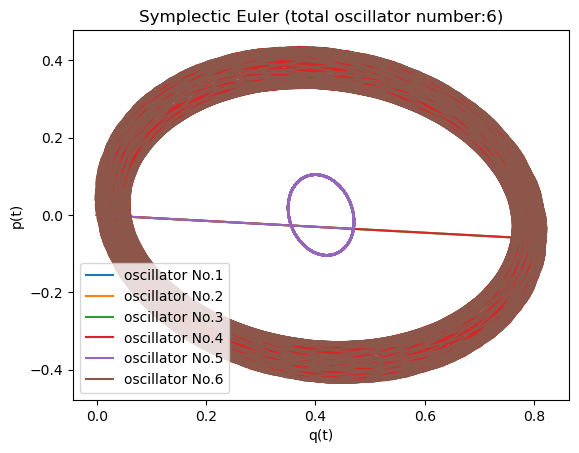

<Figure size 640x480 with 0 Axes>

In [371]:
## Phase diagram for Euler method

for n in range(M):
    label_n = "oscillator No.{number}".format(number=n+1)
    plot_s = plt.plot(q_t_s[:,n],p_t_s[:,n], label=label_n)
    
plt.xlabel("q(t)")
plt.ylabel("p(t)")
plt.title("Symplectic Euler (total oscillator number:{num})".format(num=M))
plt.legend()
plt.figure()

### *Momentum Verlet (variant of leapfrog)

It's a symplectic integrator but with higher precision (order 2 in contrast to symplectic Euler's order 1).
##### First, we need prime the pump, namely, obtain an initial value for $\dot{q_n}^{(t+dt/2)}$ using first order Euler.

\begin{equation}
\dot{q_n}^{(t+dt/2)}=p_{n}^{(t+dt/2)}=p_n^{(t)}+\frac{dt}{2}\cdot\dot{p_n}^{(t)};(intermediate\;value)\\
\end{equation}
##### Second, we can update both p and q based on the $\dot{q_n}^{(t+dt/2)}$ we just calculated.
\begin{equation}
q_n^{(t+dt)}=q_n^{(t)}+dt\cdot \dot{q_n}^{(t+dt/2)}\\
p_n^{(t+dt)}=p_n^{(t+dt/2)}+\frac{dt}{2}\cdot \dot{p_n}^{(t+dt)}\\
\end{equation}


<!-- \begin{equation}
\dot{q_n}^{(t+dt/2)}=p_n^{(t+dt/2)}=p_n^{(t)}+\frac{1}{2}dt\cdot \dot{p_n}^{(t)}
\\
q_n^{(t+dt)}=q_n^{(t)}+dt\cdot \dot{q_n}^{(t+dt/2)}
\\
p_n^{(t+dt)}=p_n^{(t)}+\frac{1}{2}dt\cdot \dot{p_n}^{(t+dt)}
\end{equation} -->

<Figure size 640x480 with 0 Axes>

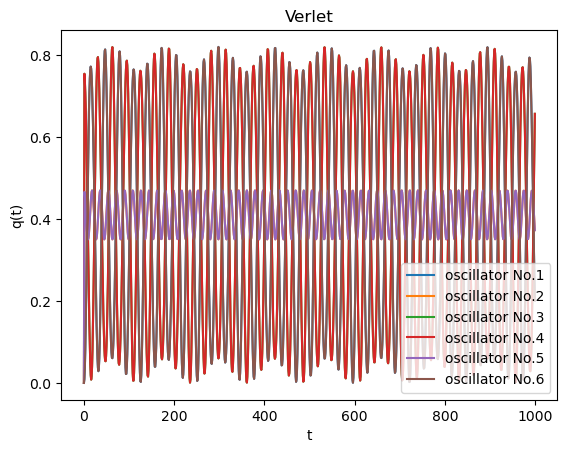

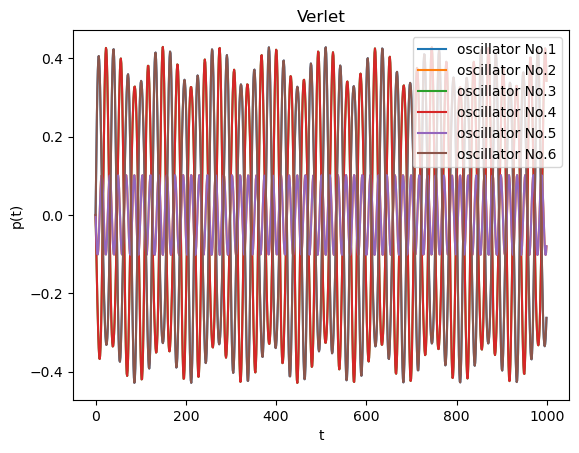

<Figure size 640x480 with 0 Axes>

In [372]:
## Using Momentum Verlet to integrate qdot and pdot

# def verlet_evol(q, p, update):
#     # q_dot = p # old q
#     q = q.copy()
#     p = p.copy()
    
#     p_dot = np.zeros(M)
#     p_dot = update(q) # old p
#     q_matrix = np.zeros([N,M]) # every column j stores the time evolution of oscillator j's position
#     p_matrix = np.zeros([N,M]) # every column j stores the time evolution of oscillator j's momentum
#     for t in range(1,N):
#         q_dot_tem = np.zeros(M)
#         for n in range(M):
#             q_dot_tem[n] = p[n]+(dt/2)*p_dot[n]
            
#             q[n] = q_dot_tem[n]*dt + q[n] 
#             p_dot = update(q) 
            
#             p[n] = p_dot[n]*(dt/2) + q_dot_tem[n]
#             # q_dot = p # In our case, q_dot just equals to p
#         q_matrix[t:]=q
#         p_matrix[t:]=p
#     return q_matrix, p_matrix

def verlet_evol(q, p, update):
    # q_dot = p # old q
    q = q.copy()
    p = p.copy()
    
    p_dot = np.zeros(M)
    p_dot = update(q) # old p
    q_matrix = np.zeros([N,M]) # every column j stores the time evolution of oscillator j's position
    p_matrix = np.zeros([N,M]) # every column j stores the time evolution of oscillator j's momentum
    for t in range(1,N):
        q_dot_tem = np.zeros(M)
        q_dot_tem = p+(dt/2)*p_dot
        q = q_dot_tem*dt + q
        p_dot = update(q) 
            
        p = p_dot*(dt/2) + q_dot_tem
            # q_dot = p # In our case, q_dot just equals to p
        q_matrix[t:]=q
        p_matrix[t:]=p
    return q_matrix, p_matrix

q_t_ver, p_t_ver = verlet_evol(q,p,p_dot_update_simp)

## Creating a label array for plotting
label_n = []
for i in range(M):
    label_n.append("oscillator No.{number}".format(number=i+1))

q_plot = plt.plot(q_t_ver)
plt.xlabel("t")
plt.ylabel("q(t)")
plt.legend(q_plot,label_n)
plt.title("Verlet")
plt.figure()

p_plot = plt.plot(p_t_ver)
plt.xlabel("t")
plt.ylabel("p(t)")
plt.legend(p_plot,label_n)
plt.title("Verlet")
plt.figure()


<Figure size 640x480 with 0 Axes>

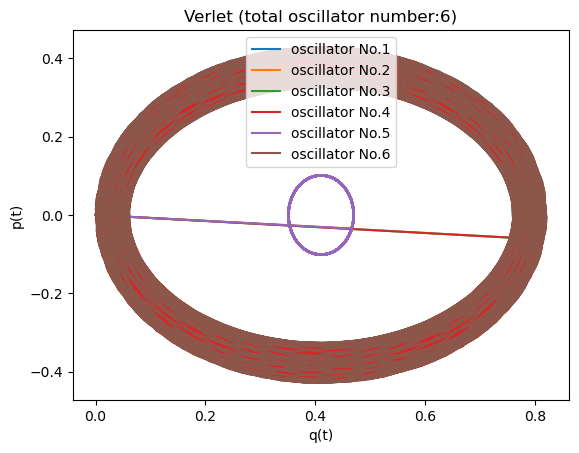

<Figure size 640x480 with 0 Axes>

In [373]:
## Phase diagram for Momentum Verlet method

for n in range(M):
    label_n = "oscillator No.{number}".format(number=n+1)
    plot_s = plt.plot(q_t_ver[:,n],p_t_ver[:,n], label=label_n)
    
plt.xlabel("q(t)")
plt.ylabel("p(t)")
plt.title("Verlet (total oscillator number:{num})".format(num=M))
plt.legend()
plt.figure()

### * Yoshida integrator (4th order)
Yoshida integrator is a higher order integrator converted from leapfrog integrator. It's very similar to Runge Kutta 4 in the sense that it introduced four intermediate steps in the following way.
#### At time $t$, let $q_n = q_n^{(t)}$
##### 1st intermediate step：
\begin{equation}
q_{n}^{(1)}=q_n+c_1p_ndt\\
\dot{p_n}^{(1)}=q_{n+1}^{(1)}+q_{n-1}^{(1)}-2q_{n}^{(1)}\\
p_{n}^{(1)}=p_n+d_1\dot{p_n}^{(1)}dt\\
\end{equation}

##### 2nd intermediate step：
\begin{equation}
q_{n}^{(2)}=q_n^{(1)}+c_2p_n^{(1)}dt\\
\dot{p_n}^{(2)}=q_{n+1}^{(2)}+q_{n-1}^{(2)}-2q_{n}^{(2)}\\
p_{n}^{(2)}=p_n^{(1)}+d_2\dot{p_n}^{(2)}dt\\
\end{equation}

##### 3rd intermediate step：
\begin{equation}
q_{n}^{(3)}=q_n^{(2)}+c_3p_n^{(2)}dt\\
\dot{p_n}^{(3)}=q_{n+1}^{(3)}+q_{n-1}^{(3)}-2q_{n}^{(3)}\\
p_{n}^{(3)}=p_n^{(2)}+d_3\dot{p_n}^{(3)}dt\\
\end{equation}

##### 4th intermediate step:
\begin{equation}
q_{n}^{(4)}=q_{n}^{(3)}+c_4p_{n}^{(3)}dt\\
p_{n}^{(4)}=p_n^{(3)}\\
\end{equation}

#### At time $t+dt$
\begin{equation}
q_{n}^{(t+dt)}:=q_{n}^{(4)}\\
p_{n}^{(t+dt)}:=p_{n}^{(4)}\\
\end{equation}

#### Coefficient $(c_1, c_2, c_3, c_4)$ and $(d_1, d_2, d_3)$ are derived by Yoshida [6] and their values are:
\begin{equation}
c_1=c_4\approx 0.6756\\
c_2=c_3\approx -0.1756\\
d_1=d_3\approx 1.3512\\
d_2\approx -1.7024
\end{equation}

<Figure size 640x480 with 0 Axes>

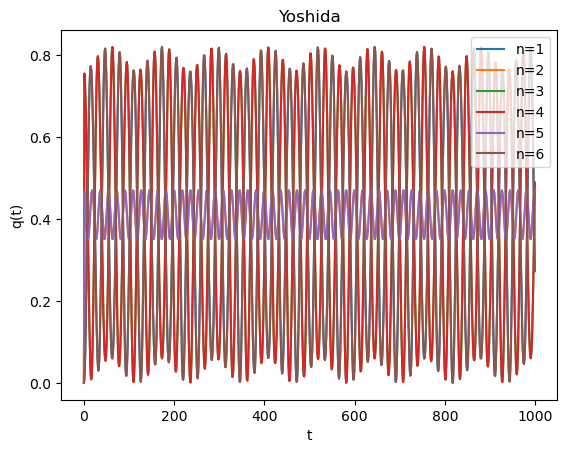

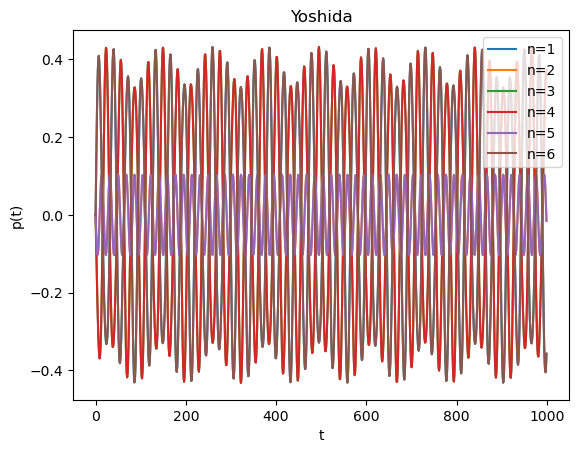

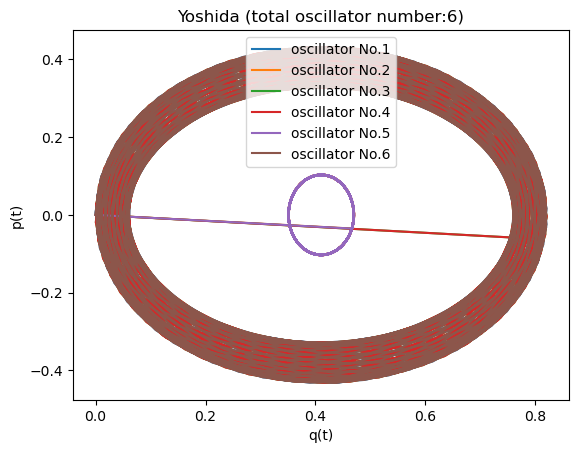

<Figure size 640x480 with 0 Axes>

In [374]:
## Using Yoshida 4 Method to integrate qdot and pdot

# Magical numbers by Yoshida
c1 = 0.6756
c4 = c1
c2 = -0.1756
c3 = c2
d1 = 1.3512
d3 = d1
d2 = -1.7024

def yoshi_evol(q,p,update):
    q = q.copy()
    p = p.copy()
    # initial p = 0, q_dot = 0
    q_matrix = np.zeros([N,M]) # every column j stores the time evolution of oscillator j's position
    p_matrix = np.zeros([N,M]) # every column j stores the time evolution of oscillator j's momentum
    for t in range(1,N):
        # q_1
        q_1 = q + c1*p*dt
        p_dot_1 = p_dot_update_simp(q_1)
        p_1 = p + d1*p_dot_1*dt
        # q_2
        q_2 = q_1 + c2*p_1*dt
        p_dot_2 = p_dot_update_simp(q_2)
        p_2 = p_1 + d2*p_dot_2*dt
        # q_3
        q_3 = q_2 + c3*p_2*dt
        p_dot_3 = p_dot_update_simp(q_3)
        p_3 = p_2 + d3*p_dot_3*dt
        # q_4
        q_4 = q_3 + c4*p_3*dt
        p_4 = p_3
        q = q_4
        p = p_4
        q_matrix[t:]=q
        p_matrix[t:]=p
    return q_matrix, p_matrix

q_t_yoshi, p_t_yoshi = yoshi_evol(q,p,p_dot_update_simp)

## Creating a label array for plotting
label_n = []
for i in range(M):
    label_n.append("n={number}".format(number=i+1))

q_plot = plt.plot(q_t_yoshi)
plt.xlabel("t")
plt.ylabel("q(t)")
plt.legend(q_plot,label_n)
plt.title("Yoshida")
plt.figure()

p_plot = plt.plot(p_t_yoshi)
plt.xlabel("t")
plt.ylabel("p(t)")
plt.legend(p_plot,label_n)
plt.title("Yoshida")
plt.figure()

for n in range(M):
    label_n = "oscillator No.{number}".format(number=n+1)
    plot_s = plt.plot(q_t_yoshi[:,n],p_t_yoshi[:,n], label=label_n)
    
plt.xlabel("q(t)")
plt.ylabel("p(t)")
plt.title("Yoshida (total oscillator number:{num})".format(num=M))
plt.legend()
plt.figure()

### *Runge Kutta 4 (not sure if it's symplectic or not)
For Runge Kutta 4 method,$q_n$ and $p_n$ are calculated in the following way:<br>
At time $t$,<br>
##### First, calculate $k_{1q}^{(t)}, k_{1p}^{(t)}$:
\begin{equation}
\dot{q_n}^{(t)} = p_n^{(t)}; (k_{1q}^{(t)})\\
\
\dot{p_n}^{(t)}=(q_{n-1}^{(t)}+q_{n+1}^{(t)}-2q_{n}^{(t)}); (k_{1p}^{(t)})\\
q_n^{(t+dt/2)}=q_n^{(t)}+\frac{dt}{2}\cdot k_{1q}^{(t)};(intermediate \; value)
\\\
p_n^{(t+dt/2)}=p_n^{(t)}+\frac{dt}{2}\cdot k_{1p}^{(t)};(intermediate \; value)
\\\
\end{equation}

##### 2nd, calculate $k_{2q}^{(t)}, k_{2p}^{(t)}$:
\begin{equation}
\dot{q_n}^{(t)} = p_n^{(t+dt/2)}; (k_{2q}^{(t)})\\
\
\dot{p_n}^{(t+dt/2)}=(q_{n-1}^{(t+dt/2)}+q_{n+1}^{(t+dt/2)}-2q_{n}^{(t+dt/2)}); (k_{2p}^{(t)})\\
q_n^{(t+dt/2)}=q_n^{(t)}+\frac{dt}{2}\cdot k_{2q}^{(t)}
\\\
p_n^{(t+dt/2)}=p_n^{(t)}+\frac{dt}{2}\cdot k_{2p}^{(t)}
\\\
\end{equation}

##### 3rd, calculate $k_{3q}^{(t)}, k_{3p}^{(t)}$:
\begin{equation}
\dot{q_n}^{(t)} = p_n^{(t+dt/2)}; (k_{3q}^{(t)})\\
\
\dot{p_n}^{(t+dt/2)}=(q_{n-1}^{(t+dt/2)}+q_{n+1}^{(t+dt/2)}-2q_{n}^{(t+dt/2)}); (k_{3p}^{(t)})\\
q_n^{(t+dt/2)}=q_n^{(t)}+\frac{dt}{2}\cdot k_{3q}^{(t)}
\\\
p_n^{(t+dt/2)}=p_n^{(t)}+\frac{dt}{2}\cdot k_{3p}^{(t)}
\\\
\end{equation}



##### 4th, calculate $k_{4q}^{(t)}, k_{4p}^{(t)}$:

\begin{equation}
\dot{q_n}^{(t)} = p_n^{(t+dt/2)}; (k_{4q}^{(t)})\\
\dot{p_n}^{(t+dt/2)}=(q_{n-1}^{(t+dt/2)}+q_{n+1}^{(t+dt/2)}-2q_{n}^{(t+dt/2)}); (k_{4p}^{(t)})
\end{equation}

##### Finally, obtain $p_n^{(t+dt)}, q_n^{(t+dt)}$ through a weight sum of $k_1, k_2, k_3, k_4$:
\begin{equation}
q_n^{(t+dt)}=q_n^{(t)}+\frac{1}{6}\cdot(k^{(t)}_{1q}+2k^{(t)}_{2q}+2k^{(t)}_{3q}+k^{(t)}_{4q})\cdot dt\\
p_n^{(t+dt)}=p_n^{(t)}+\frac{1}{6}\cdot(k^{(t)}_{1p}+2k^{(t)}_{2p}+2k^{(t)}_{3p}+k^{(t)}_{4p})\cdot dt
\end{equation}

<Figure size 640x480 with 0 Axes>

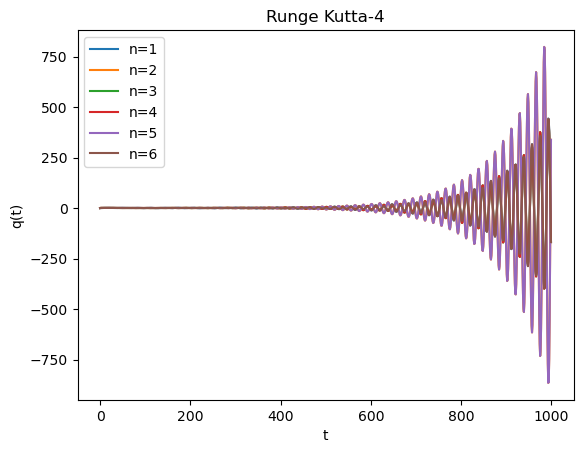

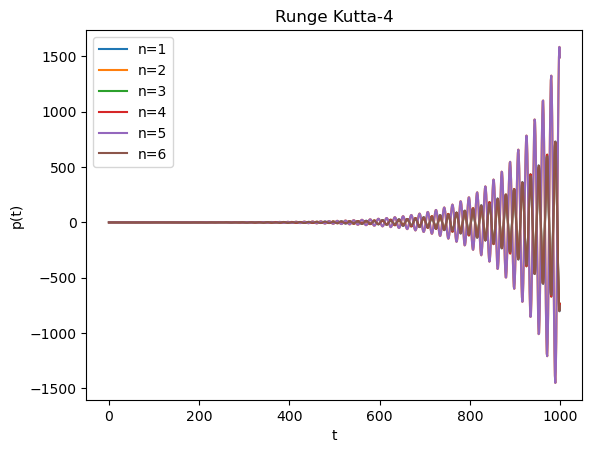

<Figure size 640x480 with 0 Axes>

In [375]:
## Using Runge Kutta 4 Method to integrate qdot and pdot

# def rk4_evol(q,p,update):
#     q = q.copy()
#     p = p.copy()
    
#     q_matrix = np.zeros([N,M]) # every column j stores the time evolution of oscillator j's position
#     p_matrix = np.zeros([N,M]) # every column j stores the time evolution of oscillator j's momentum
#     for t in range(1,N):
#         ## k_1
#         k_1q = p
#         k_1p = update(q)
#         q_tem = np.zeros(M) # Temporary q, p; to store the intermediate value for calculating k1,2,3,4
#         p_tem = np.zeros(M)
#         for n in range(M):
            
#             q_tem[n] = k_1q[n]*dt/2 + q[n] 
#             p_tem[n] = k_1p[n]*dt/2 + p[n]
            
#             ## k_2
#             k_2q = p_tem
#             k_2p = update(q_tem)
#             q_tem[n] = k_2q[n]*dt/2 + q[n]
#             p_tem[n] = k_2p[n]*dt/2 + p[n]
            
#             ## k_3
#             k_3q = p_tem
#             k_3p = update(q_tem)
#             q_tem[n] = k_3q[n]*dt/2 + q[n]
#             p_tem[n] = k_3p[n]*dt/2 + p[n]
        
#             ## k_4
#             k_4q = p_tem
#             k_4p = update(q_tem)
#             q[n] = q[n] + 1/6*(k_1q[n]+2*k_2q[n]+2*k_3q[n]+k_4q[n])*dt
#             p[n] = p[n] + 1/6*(k_1p[n]+2*k_2p[n]+2*k_3p[n]+k_4p[n])*dt
#         q_matrix[t:]=q
#         p_matrix[t:]=p
#     return q_matrix, p_matrix

def rk4_evol(q,p,update):
    q = q.copy()
    p = p.copy()
    
    q_matrix = np.zeros([N,M]) # every column j stores the time evolution of oscillator j's position
    p_matrix = np.zeros([N,M]) # every column j stores the time evolution of oscillator j's momentum
    for t in range(1,N):
        ## k_1
        k_1q = p
        k_1p = update(q)
        q_tem = np.zeros(M) # Temporary q, p; to store the intermediate value for calculating k1,2,3,4
        p_tem = np.zeros(M)
            
        q_tem = k_1q*dt/2 + q
        p_tem = k_1p*dt/2 + p
            
            ## k_2
        k_2q = p_tem
        k_2p = update(q_tem)
        q_tem = k_2q*dt/2 + q
        p_tem = k_2p*dt/2 + p
            
            ## k_3
        k_3q = p_tem
        k_3p = update(q_tem)
        q_tem = k_3q*dt/2 + q
        p_tem = k_3p*dt/2 + p
        
            ## k_4
        k_4q = p_tem
        k_4p = update(q_tem)
        q = q + 1/6*(k_1q+2*k_2q+2*k_3q+k_4q)*dt
        p = p + 1/6*(k_1p+2*k_2p+2*k_3p+k_4p)*dt
        q_matrix[t:]=q
        p_matrix[t:]=p
    return q_matrix, p_matrix

q_t, p_t = rk4_evol(q,p,p_dot_update_simp)

## Creating a label array for plotting
label_n = []
for i in range(M):
    label_n.append("n={number}".format(number=i+1))

q_plot = plt.plot(q_t)
plt.xlabel("t")
plt.ylabel("q(t)")
plt.legend(q_plot,label_n)
plt.title("Runge Kutta-4")
plt.figure()

p_plot = plt.plot(p_t)
plt.xlabel("t")
plt.ylabel("p(t)")
plt.legend(p_plot,label_n)
plt.title("Runge Kutta-4")
plt.figure()

<Figure size 640x480 with 0 Axes>

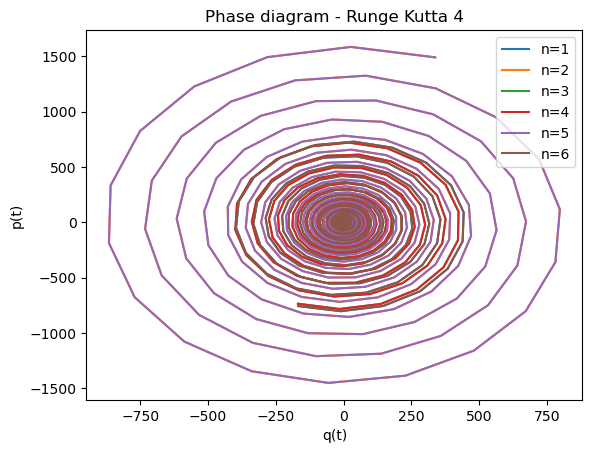

<Figure size 640x480 with 0 Axes>

In [376]:
## Phase diagram for Runge Kutta 4 (midpoint)
for n in range(M):
    label_n = "n={number}".format(number=n+1)
    plt.plot(q_t[:,n],p_t[:,n], label=label_n)
    
plt.xlabel("q(t)")
plt.ylabel("p(t)")
plt.title("Phase diagram - Runge Kutta 4")
plt.legend()
plt.figure()

## Comments (simple case)
#### From phase diagram
* Other potential integrators: **Forest-Ruth**
* Maybe we should also plot the energy evolution of the system.

## FPUT ($\alpha$ lattice)
The hamiltonian is given by:
\begin{equation}
H_\alpha(\vec{q},\vec{p})=\sum_{n=0}^{N-1}\Bigr[ \frac{p_n^2}{2}+\frac{(q_{n+1}-q_n)^2}{2}+\frac{\alpha}{3}(q_{n+1}-q_{n})^3\Bigr]
\end{equation}

With the initial condition of the following form:\
\begin{equation}
q_n^{(t=0)}=Asin(\frac{\pi n}{N})\\p_n(0)=0
\end{equation}

<!-- The dependence between $q_n$ and $p_n$ are from the hamiltonian $H_n$ is
\begin{equation}
p_n = \sqrt{2E_n-k(q_{n+1}-q_n)^2}, \\
E_n=H_n, H = \sum_{n=0}^{N-1}H_n
\end{equation} -->

then, $\dot{q_n}$ and $\dot{p_n}$ would be

\begin{equation}
\dot{q_n}^{(t)}=\frac{\partial H}{\partial p_n}=p_n^{(t)}
\\
\dot{p_n}^{(t)}=-\frac{\partial H}{\partial q_n}=(q_{n-1}^{(t)}+q_{n+1}^{(t)}-2q_n^{(t)})+\alpha(q_{n+1}^{(t)\;2}-q_{n-1}^{(t)\;2}-2q_n^{(t)} q_{n+1}^{(t)}+2q_n^{(t)} q_{n-1}^{(t)})
\end{equation}


In [377]:
alpha = 0.5

def p_dot_update_alpha(q):
    p_dot_tem = np.zeros(M)
    for i in range(M):
        if i==0: # left boundary case
            # p_dot_tem[i]=q[i+1]-2*q[i]+alpha*(q[i+1]**2-2*q[i]*q[i+1])
            p_dot_tem[i]=-2*q[i]+q[-1]+q[i+1]+alpha*(q[i+1]**2-q[-1]**2-2*q[i]*q[i+1]+2*q[i]*q[-1])
        elif i==M-1: # right boundary case
            # p_dot_tem[i]=q[i-1]-2*q[i]+alpha*(-q[i-1]**2+2*q[i]*q[i-1])
            p_dot_tem[i]=-2*q[i]+q[i-1]+q[0]+alpha*(q[0]**2-q[i-1]**2-2*q[i]*q[0]+2*q[i]*q[i-1])
        else:
            p_dot_tem[i]=-2*q[i]+q[i-1]+q[i+1]+alpha*(q[i+1]**2-q[i-1]**2-2*q[i]*q[i+1]+2*q[i]*q[i-1])
    return p_dot_tem

### Symplectic Euler

<Figure size 640x480 with 0 Axes>

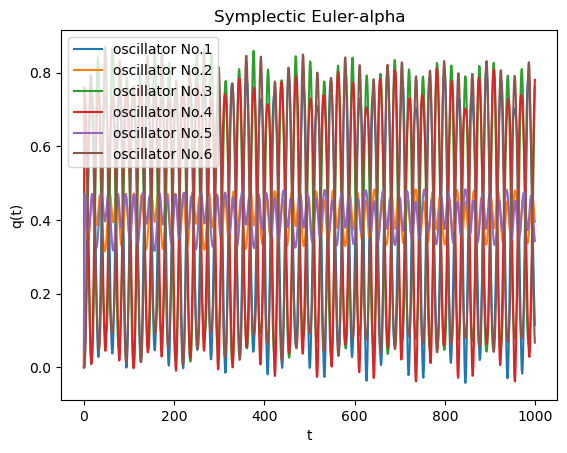

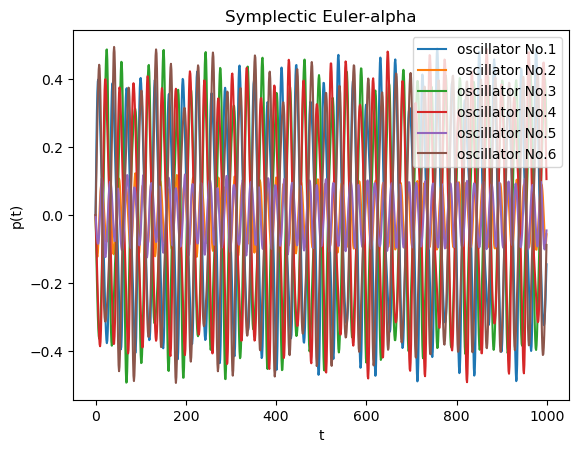

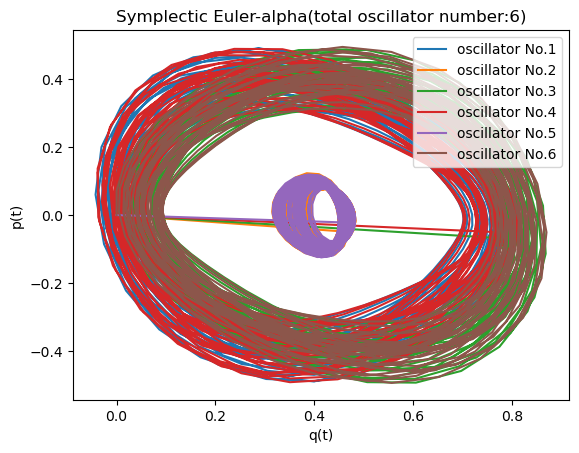

<Figure size 640x480 with 0 Axes>

In [378]:
q_t_s, p_t_s = euler_evol_sym(q,p,p_dot_update_alpha)
# q_t_ns, p_t_ns = euler_evol_non_sym(q,p,p_dot_update_simp)
        
## Creating a label array for plotting
label_n = []
for i in range(M):
    label_n.append("oscillator No.{number}".format(number=i+1))

q_plot = plt.plot(q_t_s)
plt.xlabel("t")
plt.ylabel("q(t)")
plt.legend(q_plot,label_n)
plt.title("Symplectic Euler-alpha")
plt.figure()

p_plot = plt.plot(p_t_s)
plt.xlabel("t")
plt.ylabel("p(t)")
plt.legend(p_plot,label_n)
plt.title("Symplectic Euler-alpha")
plt.figure()

## Phase diagram for Euler method

for n in range(M):
    label_n = "oscillator No.{number}".format(number=n+1)
    plot_s = plt.plot(q_t_s[:,n],p_t_s[:,n], label=label_n)
    
plt.xlabel("q(t)")
plt.ylabel("p(t)")
plt.title("Symplectic Euler-alpha(total oscillator number:{num})".format(num=M))
plt.legend()
plt.figure()

### Verlet

<Figure size 640x480 with 0 Axes>

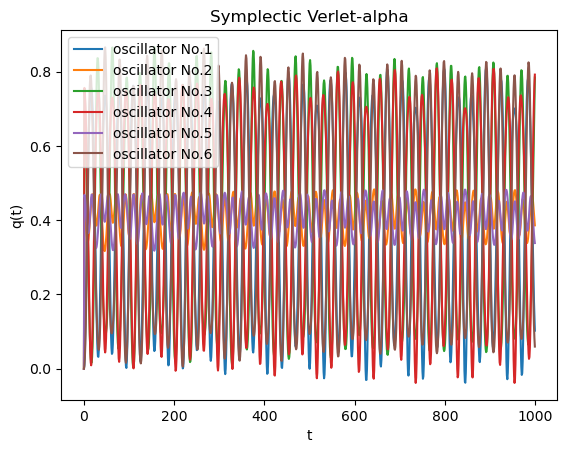

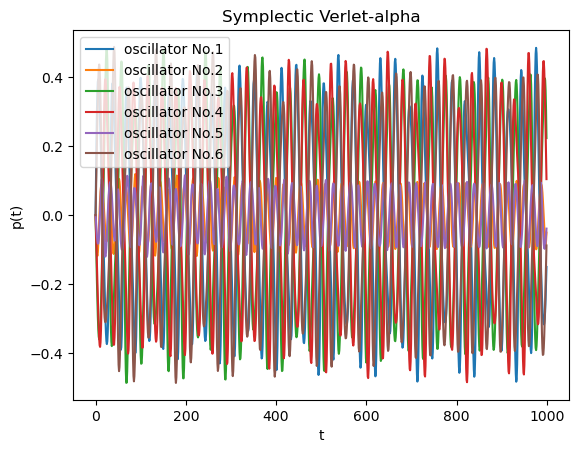

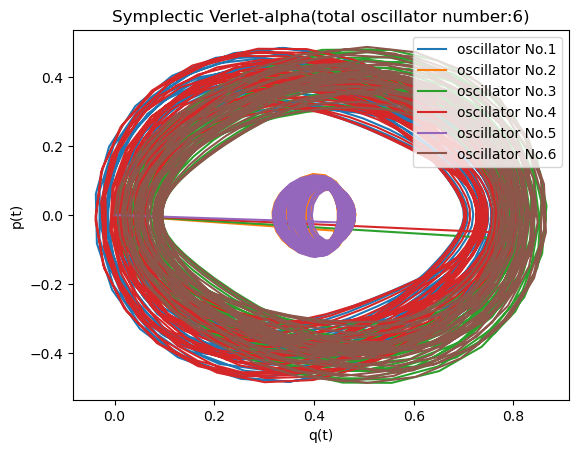

<Figure size 640x480 with 0 Axes>

In [379]:
q_t_ver, p_t_ver = verlet_evol(q,p,p_dot_update_alpha)

## Creating a label array for plotting
label_n = []
for i in range(M):
    label_n.append("oscillator No.{number}".format(number=i+1))

q_plot = plt.plot(q_t_ver)
plt.xlabel("t")
plt.ylabel("q(t)")
plt.legend(q_plot,label_n)
plt.title("Symplectic Verlet-alpha")
plt.figure()

p_plot = plt.plot(p_t_ver)
plt.xlabel("t")
plt.ylabel("p(t)")
plt.legend(p_plot,label_n)
plt.title("Symplectic Verlet-alpha")
plt.figure()

## Phase diagram for Verlet method

for n in range(M):
    label_n = "oscillator No.{number}".format(number=n+1)
    plot_s = plt.plot(q_t_ver[:,n],p_t_ver[:,n], label=label_n)
    
plt.xlabel("q(t)")
plt.ylabel("p(t)")
plt.title("Symplectic Verlet-alpha(total oscillator number:{num})".format(num=M))
plt.legend()
plt.figure()

#### The above curve is called Lissajous Curve

### Yoshida

<Figure size 640x480 with 0 Axes>

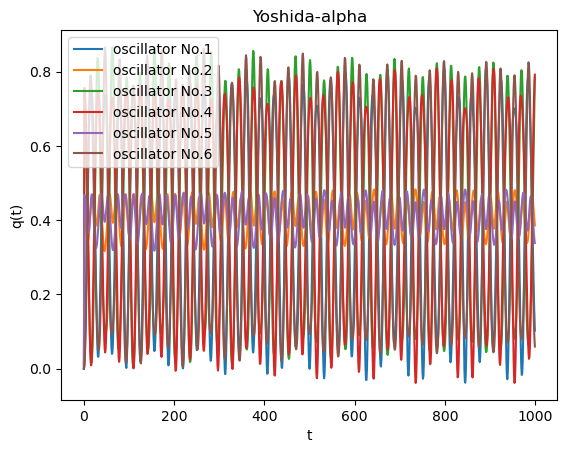

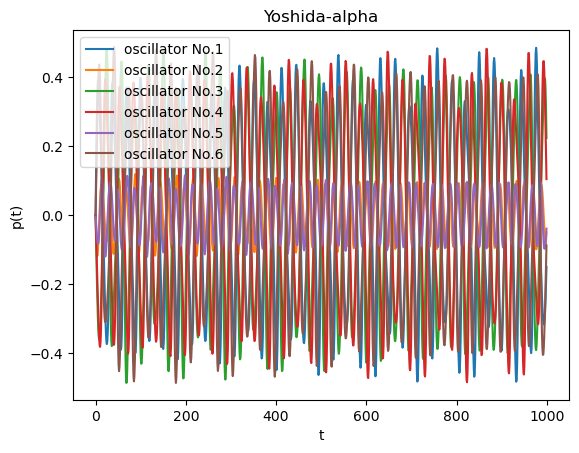

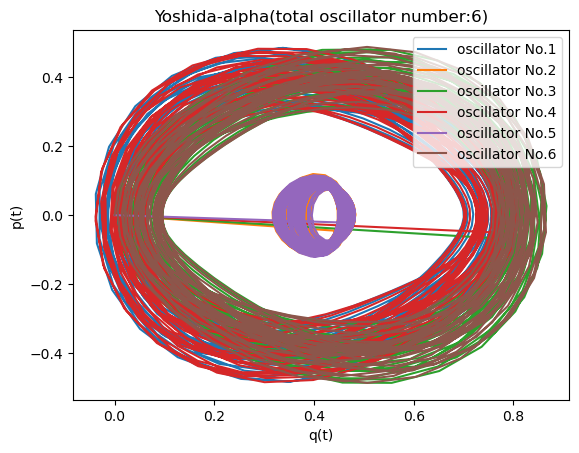

<Figure size 640x480 with 0 Axes>

In [380]:
q_t_yoshi, p_t_yoshi = yoshi_evol(q,p,p_dot_update_alpha)

## Creating a label array for plotting
label_n = []
for i in range(M):
    label_n.append("oscillator No.{number}".format(number=i+1))

q_plot = plt.plot(q_t_ver)
plt.xlabel("t")
plt.ylabel("q(t)")
plt.legend(q_plot,label_n)
plt.title("Yoshida-alpha")
plt.figure()

p_plot = plt.plot(p_t_ver)
plt.xlabel("t")
plt.ylabel("p(t)")
plt.legend(p_plot,label_n)
plt.title("Yoshida-alpha")
plt.figure()

## Phase diagram for Verlet method

for n in range(M):
    label_n = "oscillator No.{number}".format(number=n+1)
    plot_s = plt.plot(q_t_ver[:,n],p_t_ver[:,n], label=label_n)
    
plt.xlabel("q(t)")
plt.ylabel("p(t)")
plt.title("Yoshida-alpha(total oscillator number:{num})".format(num=M))
plt.legend()
plt.figure()